# Satellite Data Acquisition - Quick Start: Single Image Download (S2MPC)

Simple example to download a Sentinel-2 image from Microsoft Planetary Computer.

Author: Peter Kongstad

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, Point

from sat_data_acquisition import SatDataClient, ProcessingParams, SaveParams, configure_logging
from sat_data_acquisition.processing import save_data
from sat_data_acquisition.config.settings import SatDataSettings

In [3]:
# Configure logging
configure_logging(verbose=False)

## Define Area of Interest

Create a bounding box around Copenhagen.

In [4]:
# Define area as bounding box (rectangular shape)
copenhagen_center = Point(12.5683, 55.6761)  # lon, lat
buffer = 0.024  # ~5 km

geometry = box(
    copenhagen_center.x - buffer,
    copenhagen_center.y - buffer,
    copenhagen_center.x + buffer,
    copenhagen_center.y + buffer
)

print(f"Area bounds: {geometry.bounds}")
print(f"Approximate area: {(buffer * 111 * 2)**2:.1f} km²")

Area bounds: (12.544300000000002, 55.6521, 12.5923, 55.7001)
Approximate area: 28.4 km²


## Download Image

Search for a recent Sentinel-2 image from Microsoft Planetary Computer with low cloud coverage.

In [5]:
# Initialize client
client = SatDataClient()
settings = SatDataSettings()

# Configure processing parameters
processing_params = ProcessingParams(
    satellite='S2MPC',
    search_method='geometry',
    start_date='2024-06-01',
    end_date='2024-07-31',
    bands=['red', 'green', 'blue'],
    cloud_coverage=20,
    clip_method='geometry'
)

# Search and download
dataset = client.search_and_create_image(
    geometry=geometry,
    processing_params=processing_params,
    area_name='copenhagen'
)

print(f"Downloaded {len(dataset.time)} images")
if len(dataset.time) > 0:
    date_str = str(dataset.time.values[0])[:10]
    print(f"Image date: {date_str}")
    print(f"Image shape: {dataset.dims}")

Downloaded 1 images
Image date: 2024-06-02
Image shape: FrozenMappingWarningOnValuesAccess({'y': 545, 'x': 320, 'time': 1})


## Visualize True Color Image (TCI)

Display the RGB bands as a true color composite.

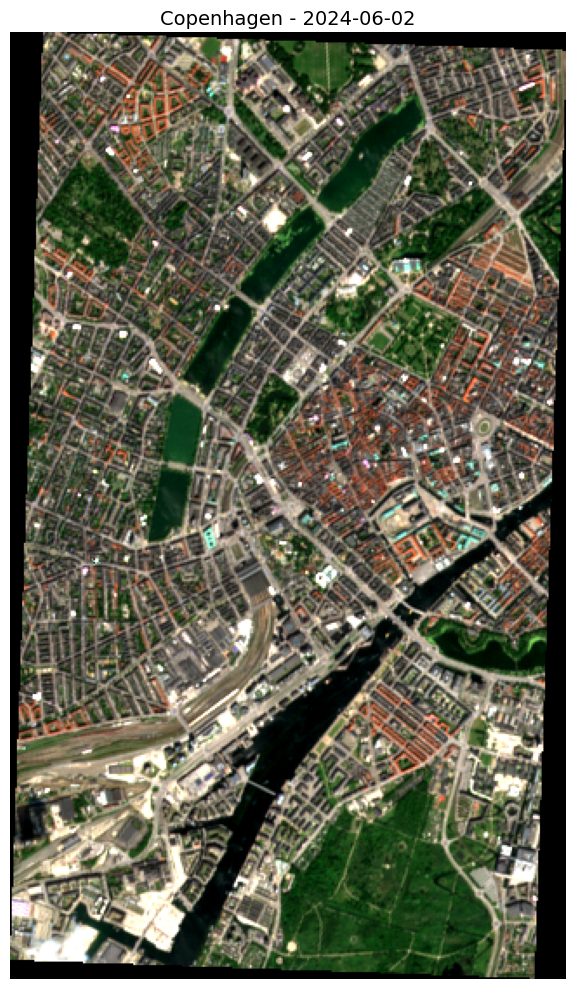

In [6]:
if len(dataset.time) > 0:
    # Get the first image
    image_slice = dataset.sel(time=dataset.time.values[0])
    date_str = str(dataset.time.values[0])[:10]
    
    # Extract RGB bands
    rgb = image_slice.to_array().values[:3].transpose(1, 2, 0)
    
    # Percentile stretch for natural-looking TCI
    valid_pixels = rgb[rgb > 0]
    if len(valid_pixels) > 0:
        p2, p98 = np.percentile(valid_pixels, [2, 98])
        rgb_stretched = np.clip((rgb - p2) / (p98 - p2), 0, 1)
        rgb_corrected = np.power(rgb_stretched, 0.9)  # Gamma correction for better visualization

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_corrected)
    plt.title(f'Copenhagen - {date_str}', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No images found for the specified criteria")

## Save to GeoTIFF

Save the downloaded image to a GeoTIFF file.

In [7]:
if len(dataset.time) > 0:
    # Configure save parameters
    save_params = SaveParams(
        output_path="../data/images",
        save_to_local=True,
        save_as_geotiff=True
    )
    
    # Save using the clean save_data interface
    save_data(
        image=image_slice,
        identifier="copenhagen",
        datetime=date_str,
        satellite=processing_params.satellite,
        provider="MPC",
        save_params=save_params
    )
    
    print(f"Image saved to: ../data/images/S2MPC/{date_str[:4]}/tiff/")

Image saved to: ../data/images/S2MPC/2024/tiff/


## Next Steps

- Try the [multi_image_download.ipynb](multi_image_download.ipynb) example for time series and multiple areas
- Adjust `cloud_coverage`, `start_date`, and `end_date` parameters
- Add more bands (e.g., 'nir', 'swir16') for analysis
- See [../README.md](../README.md) for more advanced features